# Environment and Simulation Setup
## Creating and Sourcing URDF Files

This tasks includes the meshes (`.stl` files), collision geometry, and `.urdf` files for each object. We plan to use the Franka panda robotic arm, which is the same arm purchased in our research group (the Computational Robotics Lab at Harvard).

In [26]:
import os
import pydot

from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from IPython.display import HTML, SVG, display
from pydrake.visualization import ModelVisualizer
from pydrake.all import Simulator, StartMeshcat, DiagramBuilder, MeshcatVisualizer, namedview

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario

### Jenga Blocks and Table

In [27]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [28]:
def make_stack():
    output = ''
    num_layers = 18 # actual number is 18, but use a smaller number to speed up sim setup
    num_blocks_per_layer = 3
    block_width = 0.025
    block_height = 0.015
    for i in range(num_layers):
        # alternate block orientations
        layer_in_x_direction = i % 2 == 0
        for j in range(num_blocks_per_layer):
            x = (block_width * (j - 1)) if layer_in_x_direction else 0
            y = 0 if layer_in_x_direction else (block_width * (j - 1))
            z = block_height * (i + 0.5)
            orientation = "{ deg: [0, 0, 0] }" if layer_in_x_direction else "{ deg: [0, 0, 90] }"
            output += f"""
- add_model:
    name: block_{i * 3 + j}
    file: package://jengabot/models/jenga_block.sdf
    default_free_body_pose:
        jenga_block_link:
            translation: [{x}, {y}, {z}]
            rotation: !Rpy {orientation}"""
    return output

In [29]:
def create_scene():
    scenario_data = """
directives:
- add_model:
    name: table_top
    file: package://jengabot/models/table_top.sdf
- add_weld:
    parent: world
    child: table_top::table_top_link
"""

    camera_data = """
    - add_frame:
        name: camera0_origin
        X_PF:
            base_frame: world
            rotation: !Rpy { deg: [0, 0, 0]}
            translation: [0, 1, 1]
    cameras:
        camera0:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera0_origin
    """

    scenario_data += make_stack()
    # scenario_data += camera_data
    print(scenario_data)
    
    scenario = load_scenario(data=scenario_data)
    station = DiagramBuilder()
    
    station = MakeHardwareStation(scenario, meshcat, package_xmls=['./package.xml'])
    #station = builder.AddSystem(MakeHardwareStation(scenario, meshcat, package_xmls=['./package.xml']))
    #context = station.CreateDefaultContext()


    simulator = Simulator(station)

    
    
    meshcat.StartRecording()
    simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
    meshcat.PublishRecording()


create_scene()


directives:
- add_model:
    name: table_top
    file: package://jengabot/models/table_top.sdf
- add_weld:
    parent: world
    child: table_top::table_top_link

- add_model:
    name: block_0
    file: package://jengabot/models/jenga_block.sdf
    default_free_body_pose:
        jenga_block_link:
            translation: [-0.025, 0, 0.0075]
            rotation: !Rpy { deg: [0, 0, 0] }
- add_model:
    name: block_1
    file: package://jengabot/models/jenga_block.sdf
    default_free_body_pose:
        jenga_block_link:
            translation: [0.0, 0, 0.0075]
            rotation: !Rpy { deg: [0, 0, 0] }
- add_model:
    name: block_2
    file: package://jengabot/models/jenga_block.sdf
    default_free_body_pose:
        jenga_block_link:
            translation: [0.025, 0, 0.0075]
            rotation: !Rpy { deg: [0, 0, 0] }
- add_model:
    name: block_3
    file: package://jengabot/models/jenga_block.sdf
    default_free_body_pose:
        jenga_block_link:
            transla

KeyboardInterrupt: 

### Load Robot Model

In [30]:
meshcat.Delete()
meshcat = StartMeshcat()



INFO:drake:Meshcat listening for connections at http://localhost:7004


In [31]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""
scenario = load_scenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat=meshcat)
context = station.CreateDefaultContext()

station.GetInputPort("wsg.position").FixValue(context, [0.1])
station.ForcedPublish(context)

In [32]:
# initialize context
station_context = station.CreateDefaultContext()
plant = station.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(station_context)

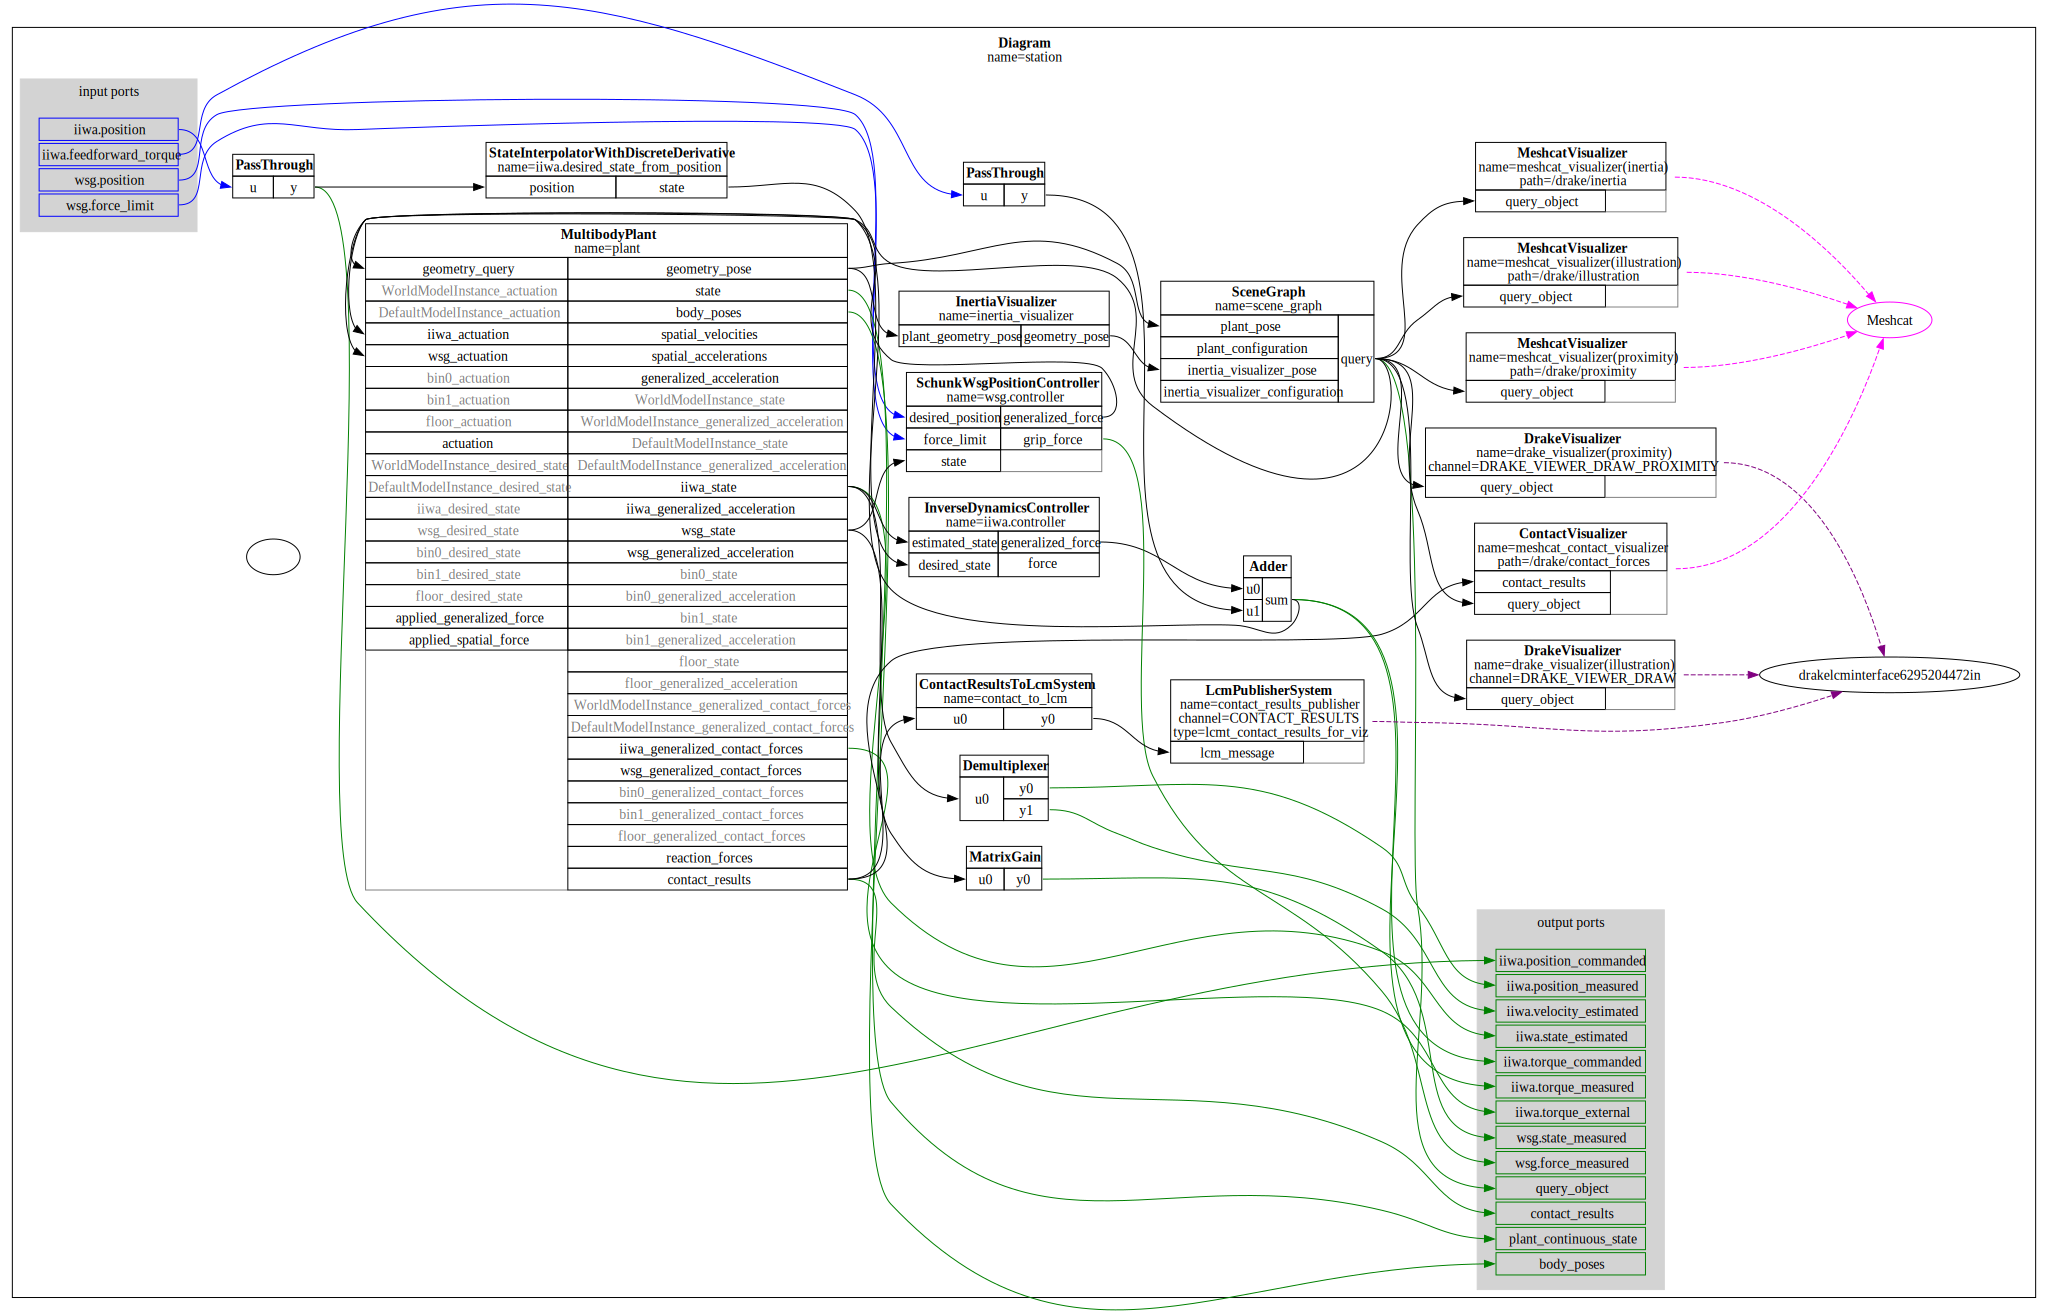

In [33]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

In [34]:
# provide initial states
import numpy as np
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
iiwa = plant.GetModelInstanceByName("iiwa")
# set the joint positions of the kuka arm
plant.SetPositions(plant_context, iiwa, q0)
# examine the output port
station.GetOutputPort("iiwa.position_measured").Eval(station_context)

array([-1.57,  0.1 ,  0.  , -1.2 ,  0.  ,  1.6 ,  0.  ])

In [35]:
IiwaPositionView = namedview(
    "IiwaPositions",
    plant.GetPositionNames(iiwa, always_add_suffix=False),
)
q0 = IiwaPositionView.Zero()
q0.iiwa_joint_1 = -1.57
q0.iiwa_joint_2 = 0.1
q0.iiwa_joint_4 = -1.2
q0.iiwa_joint_6 = 1.6
print(q0)
plant.SetPositions(plant_context, iiwa, q0[:])

IiwaPositions(iiwa_joint_1=-1.57, iiwa_joint_2=0.1, iiwa_joint_3=0, iiwa_joint_4=-1.2, iiwa_joint_5=0, iiwa_joint_6=1.6, iiwa_joint_7=0)


## Camera Setup